In [18]:
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver
import os

In [19]:
load_dotenv()

True

In [20]:
model = ChatOpenAI(
    model="xiaomi/mimo-v2-flash:free",
    api_key=os.environ.get('OPEN_ROUTER_API_KEY'),
    base_url="https://openrouter.ai/api/v1",
)

In [21]:
class ChatState(MessagesState):
    summary: str

In [22]:
def summarize_conversation(state: ChatState):

    existing_summary = state["summary"]

    # Build summarization prompt
    if existing_summary:
        prompt = (
            f"Existing summary:\n{existing_summary}\n\n"
            "Extend the summary using the new conversation above."
        )
    else:
        prompt = "Summarize the conversation above."

    messages_for_summary = state["messages"] + [
        HumanMessage(content=prompt)
    ]

    response = model.invoke(messages_for_summary)

    # Keep only last 2 messages verbatim
    messages_to_delete = state["messages"][:-2]

    return {
        "summary": response.content,
        "messages": [RemoveMessage(id=m.id) for m in messages_to_delete],
    }

In [23]:
def chat_node(state: ChatState):
    messages = []

    if state["summary"]:
        messages.append({
            "role": "system",
            "content": f"Conversation summary:\n{state['summary']}"
        })

    messages.extend(state["messages"])

    print(messages)

    response = model.invoke(messages)
    return {"messages": [response]}

In [24]:
def should_summarize(state: ChatState):
    return len(state["messages"]) > 6

In [25]:
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)
builder.add_node("summarize", summarize_conversation)

builder.add_edge(START, "chat")

builder.add_conditional_edges(
    "chat",
    should_summarize,
    {
        True: "summarize",
        False: "__end__",
    }
)

builder.add_edge("summarize", "__end__")

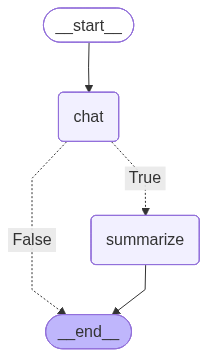

In [26]:
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)
graph

In [27]:
config = {"configurable": {"thread_id": "t1"}}

def run_turn(text: str):
    out = graph.invoke({"messages": [HumanMessage(content=text)], "summary": ""}, config=config)
    return out

In [28]:

def show_state():
    snap = graph.get_state(config)
    vals = snap.values
    print("\n--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])

In [29]:
run_turn('Quantum Physics')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='338f2252-1af8-4c00-afe0-9948107e6b66')]

--- STATE ---
summary: 
num_messages: 2
messages:
- HumanMessage : Quantum Physics
- AIMessage : Hello! I am MiMo, and I'm happy to discuss quantum physics with you.

Quantum ph


In [30]:
run_turn('How is Albert Einstien related?')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='338f2252-1af8-4c00-afe0-9948107e6b66'), AIMessage(content='Hello! I am MiMo, and I\'m happy to discuss quantum physics with you.\n\nQuantum physics (also known as quantum mechanics) is the fundamental theory in physics that describes the behavior of nature at the smallest scales of energy and matter. It\'s a fascinating, often mind-bending field that challenges our everyday intuition.\n\nHere is a beginner-friendly guide to some of the core concepts that make quantum physics so unique:\n\n### 1. Quantization: Energy Comes in Packets\nIn classical physics (the physics of everyday objects), energy was thought to be continuous—like a smooth ramp. Quantum physics discovered that energy actually comes in discrete "packets" called **quanta**.\n\n*   **The Analogy:** Think of a staircase versus a ramp. In a staircase, you can only stand on specific steps (discrete levels); you can\'t stand halfway between

In [31]:
run_turn('What are some of Einstien"s fampus work')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='338f2252-1af8-4c00-afe0-9948107e6b66'), AIMessage(content='Hello! I am MiMo, and I\'m happy to discuss quantum physics with you.\n\nQuantum physics (also known as quantum mechanics) is the fundamental theory in physics that describes the behavior of nature at the smallest scales of energy and matter. It\'s a fascinating, often mind-bending field that challenges our everyday intuition.\n\nHere is a beginner-friendly guide to some of the core concepts that make quantum physics so unique:\n\n### 1. Quantization: Energy Comes in Packets\nIn classical physics (the physics of everyday objects), energy was thought to be continuous—like a smooth ramp. Quantum physics discovered that energy actually comes in discrete "packets" called **quanta**.\n\n*   **The Analogy:** Think of a staircase versus a ramp. In a staircase, you can only stand on specific steps (discrete levels); you can\'t stand halfway between

In [32]:
run_turn('Explain special theory of relativity')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='338f2252-1af8-4c00-afe0-9948107e6b66'), AIMessage(content='Hello! I am MiMo, and I\'m happy to discuss quantum physics with you.\n\nQuantum physics (also known as quantum mechanics) is the fundamental theory in physics that describes the behavior of nature at the smallest scales of energy and matter. It\'s a fascinating, often mind-bending field that challenges our everyday intuition.\n\nHere is a beginner-friendly guide to some of the core concepts that make quantum physics so unique:\n\n### 1. Quantization: Energy Comes in Packets\nIn classical physics (the physics of everyday objects), energy was thought to be continuous—like a smooth ramp. Quantum physics discovered that energy actually comes in discrete "packets" called **quanta**.\n\n*   **The Analogy:** Think of a staircase versus a ramp. In a staircase, you can only stand on specific steps (discrete levels); you can\'t stand halfway between